In [607]:
import yfinance as yf #Yahoo Finance API for downloading stock market data
import pandas as pd 
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from datetime import datetime
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

# Stocks Prediction with Prophet and LSTM

## Prophet

Our goal with this notebook is to use Facebooks's Prophet and a LSTM to predict the Stock Market for the next year.
In the end, we will compare both models. 

In [661]:
# We will use the data starting from BEGIN_DATA till TODAY_DATA

BEGIN_DATA = '2019-1-1'
TODAY_DATA = datetime.now().strftime('%Y-%m-%d') #datetime module to get todays date

First, let's warm-up with Prophet model for AAPL. For now, we will use the closing value for each day as data.   

In [609]:
def load_data(BEGIN_DATA = BEGIN_DATA, company = yf.Ticker("AAPL")):

    history = company.history(start=BEGIN_DATA, end=TODAY_DATA).reset_index()[['Date','Close']].rename(columns = {'Date':'ds', 'Close':'y'}) #data mast have ds and y columns
    history.ds = history.ds.dt.tz_convert(None)

    return history;

class Pmodel():

    '''Pmodel takes as argument the initial date for the data, company, period (in days) for future predictions, and loader of data.
    Pmodel fits automatically when called.
    
    Use internal function plotpred() to plot predictions '''


    def __init__(self, BEGIN_DATA = BEGIN_DATA, company = yf.Ticker("AAPL"), periods = 365, loader = load_data):
        self.BEGIN = BEGIN_DATA
        self.company = company
        self.periods = periods
        self.data = loader(self.BEGIN, self.company)

        self.model = Prophet()   #create model
        self.model.fit(self.data)  #fit date to model

        future = self.model.make_future_dataframe(periods=self.periods)   #make future dataframe
        self.hist = self.model.predict(future)                             #predict dataframe

        self.pred = self.hist[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        self.components = self.hist[['ds','trend','trend_lower','trend_upper','weekly','weekly_lower','weekly_upper','yearly','yearly_lower','yearly_upper']]
        
    def plotpred(self,):  

        return plot_plotly(self.model, self.hist, xlabel = 'Date', ylabel = 'Closing Price',);  #plot predictions

    def plotcomponents(self,):  # plot component: trend, yearly, weekly
        
        return plot_components_plotly(self.model, self.hist)


In [612]:
model = Pmodel()
model.plotpred() 

04:46:58 - cmdstanpy - INFO - Chain [1] start processing
04:46:58 - cmdstanpy - INFO - Chain [1] done processing


On first sight, we see that the model is capable of fitting the data really well, and it gives a more or less behaved prediction for the future.

We can also plot the components:

In [613]:
model.plotcomponents()

Here we see that based on this model, if we are looking for a quick profit, it makes sense to buy during the week (closing value is the lowest), and sell during sunday (closing value is the highest).

It's worth mentioning here that I chose the BEGIN_DATA = 2019 for a very specific reason. If we look at the previous behavior of the closing price (before 2019):


In [614]:
model = Pmodel(BEGIN_DATA = '2010-1-1')


04:47:25 - cmdstanpy - INFO - Chain [1] start processing
04:47:26 - cmdstanpy - INFO - Chain [1] done processing


In [615]:
model.plotpred()

we see that Apple had a pretty steady growing trend before 2019 with a big fall in NOV 2018, and its biggest fall in FEB 2020. After FEB 2020, the fluctuations of the price are also much bigger than before. It's reasonable to assume that this behavior is consequence of the COVID Pandemic. Since the Prophet is based on an additive model of non-linear trends, if we train the model on the whole data, where the market behavior was completely different, we will add too much weight to trends that may not be valid anymore for the Post-Covid market. We can see from the graph above that the future predictions don't seem to have the same kind of fluctuations from the Post Covid time, this is very different in the first model we did starting from 2019. 

We can see that this argument is reasonable if we look at the whole NASDAQ Composite behavior. 

In [616]:
model = Pmodel(BEGIN_DATA = '2010-1-1', company = yf.Ticker('^IXIC'))

04:47:40 - cmdstanpy - INFO - Chain [1] start processing
04:47:41 - cmdstanpy - INFO - Chain [1] done processing


In [617]:
model.plotpred()

As expected, we notice a very accentuated difference in behavior after the end of 2019.

It is a good practice to normalize our dataset, that is why we will construct the following loader:

In [618]:
def load_data_norm(BEGIN_DATA = BEGIN_DATA, company = yf.Ticker("AAPL")):

    history = company.history(start=BEGIN_DATA, end=TODAY_DATA).reset_index()[['Date','Close']].rename(columns = {'Date':'ds', 'Close':'y'}) #data mast have ds and y columns
    history.ds = history.ds.dt.tz_convert(None)
    mean = history.y.mean(axis=0)
    std = history.y.std(axis=0)
    history['y'] = (history['y'] - mean)/std
    
    return history

def load_data_minmax(BEGIN_DATA = BEGIN_DATA, company = yf.Ticker("AAPL")):
    
    history = company.history(start=BEGIN_DATA, end=TODAY_DATA).reset_index()[['Date','Close']].rename(columns = {'Date':'ds', 'Close':'y'}) #data mast have ds and y columns
    history.ds = history.ds.dt.tz_convert(None)
    history['y'] = (history['y'] - history['y'].min()) / (history['y'].max() - history['y'].min())

    return history
    

In [619]:
model = Pmodel(loader = load_data_minmax)

04:48:02 - cmdstanpy - INFO - Chain [1] start processing
04:48:03 - cmdstanpy - INFO - Chain [1] done processing


In [620]:
model.plotpred()

The problem with using all our data until today is that it is difficult to evaluate metrics for this model. One of the possible ways is to use cross-validation, and indeed, Facebook Prophet hava built-in ``cross_validation``, ``performance_metrics`` to help us with that. 

Instead of using the built-in tools, what we will do is to divide our data into validation and training data. The validation data will be the last 20 days of our data. It is important for the validation to be small because we need as much current data as possible. If we are trying to predict the market for the short term, the performance for the next 20 days is more relevant.

In [758]:
def load_val(BEGIN_DATA = BEGIN_DATA, company = yf.Ticker("AAPL")):
    data = load_data_norm(BEGIN_DATA, company)
    train_data = data[:len(data)-20]                    #last 20 days

    return train_data

In [889]:
model = Pmodel(loader = load_val, periods=100)      #Re-train the model for the new data

06:19:53 - cmdstanpy - INFO - Chain [1] start processing
06:19:53 - cmdstanpy - INFO - Chain [1] done processing


In [890]:
def accuracy(model):                    #We only evaluate the accuracy in those 20 days of prediction

    data = load_data_norm()
    pred = model.hist[len(data)-20:len(data)]
    target = data[len(data)-20:].y
    
    predmax = pred['yhat_upper']
    predmin = pred['yhat_lower']

    a = ((target < predmax)*(target > predmin)).sum()
        
    return print(f'The accuracy is = {a/len(target)*100} %')
    

In [891]:
accuracy(model)

The accuracy is = 60.0 %


In [902]:
def val_loss(model):                    #We only evaluate the accuracy in those 20 days of prediction

    data = load_data_norm()

    MSE = ((model.hist[len(data)-20:len(data)].yhat - data[len(data)-20:].y)**2).mean()
            
    return print(f'The validation loss is = {MSE}')

In [903]:
val_loss(model)

The validation loss is = 0.033071435589437634


So we get an accuracy of 60% for the last 20 days.

Text(0.5, 1.0, 'Predictions for the next 20 days')

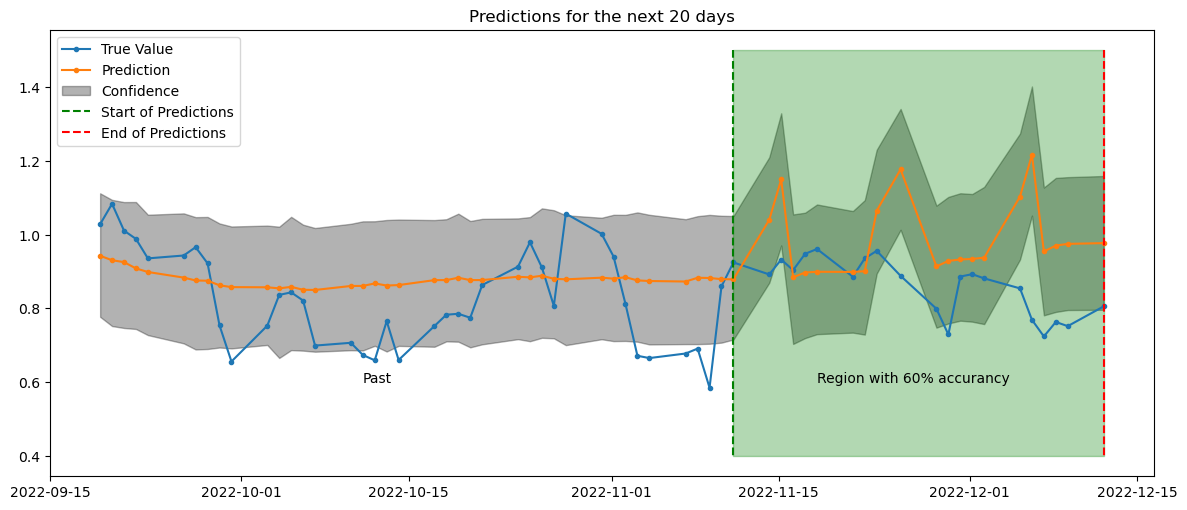

In [770]:
data = load_data_norm()
pred = model.hist
target = data[len(data)-20:len(data)].y
predmax = pred['yhat_upper']
predmin = pred['yhat_lower']

plt.figure(figsize = (12,5))
plt.plot(data.ds.iloc[-60:],data.y.iloc[-60:], '.-',label = 'True Value',)
plt.plot(data.ds.iloc[-60:].array, pred.yhat.iloc[len(data)-60:-80].array,'.-', label = 'Prediction')
plt.fill_between(data.ds.iloc[-60:], predmax.iloc[len(data)-60:-80].array, predmin.iloc[len(data)-60:-80].array, color = 'black', alpha = 0.3, edgecolor = 'k', label = 'Confidence')
plt.vlines(data.ds.iloc[len(data)-21], 1.5,0.4, linestyles='--', color='green', label = 'Start of Predictions')
plt.vlines(data.ds.iloc[-1], 1.5,0.4, linestyles='--', color='red', label = 'End of Predictions')
plt.fill_betweenx(y = torch.arange(0.4,1.55,0.1), x1 = data.ds.iloc[-1], x2 = data.ds.iloc[len(data)-21], color='green', alpha = 0.3)
plt.text(x = data.ds.iloc[-16] , y = 0.6, s= 'Region with 60''%'' accurancy')
plt.text(x = data.ds.iloc[-44] , y = 0.6, s= 'Past')
plt.tight_layout()
plt.legend(loc= 'upper left')
plt.title('Predictions for the next 20 days')

Even by getting an accuracy of 60%, we see, by inspection, that our model does not seen like a trustworthy model. In fact, the stock market has very chaotic behavior, and expecting to be able to predict it using a simple addictive algorithm is very naive. As we can see, the model expects some sort of periodic behavior that does not explain reality. We have to be very careful when using such a model, but we still can use it as a base to analyze trends.

side note: we used the most simple Prophet model, in fact, Prophet has many other tools that could improve our results. We could, for example, define a set of dates where the model is suppose to expect different behaviors... these dates could be holidays, or covid days. 

## LSTM 

Now let's move on to our LSTM.
Neural Networks are a very powerful tool to solve many problems in Machine Learning. Here we are going to use a very simple LSTM to predict the stock market. We could always improve our LSTM, but the amount of computation required goes beyond the limits of a domestic computer, and beyond the scope of this project.

Our LSTM will have 2 layers, and hidden dimension = 264. To make a future prediction, the LSTM is trained using the closing price one-by-one, and as target for the loss function we will use the next closing price of the given one at the current step.

In [782]:
class RNN(nn.Module):
    
    def __init__(self, hidden_dim):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.lstm1 = nn.LSTMCell(1, self.hidden_dim)                   #first layer
        self.lstm2 = nn.LSTMCell(self.hidden_dim, self.hidden_dim)                  #second layer
        # self.lstm3 = nn.LSTMCell(self.hidden_dim,self.hidden_dim)  
        self.linear1 = nn.Linear(self.hidden_dim, 1)                    #final layer for predictions

    def forward(self, input, period = 0):

        outputs = []
        h_t = torch.zeros(input.size(0), self.hidden_dim, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_dim, dtype=torch.float32)
        h_t2 = torch.zeros(input.size(0), self.hidden_dim, dtype=torch.float32)
        c_t2 = torch.zeros(input.size(0), self.hidden_dim, dtype=torch.float32)
        # h_t3 = torch.zeros(input.size(0), self.hidden_dim, dtype=torch.float32)
        # c_t3 = torch.zeros(input.size(0), self.hidden_dim, dtype=torch.float32)

        for input_t in input.split(1, dim=1):                     

            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            # h_t3, c_t3 = self.lstm3(h_t2, (h_t3,c_t3))
            output = self.linear1(h_t2)
            
            outputs.append(output)

        for i in range(period):               # if we want to predict the future

            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            # h_t3, c_t3 = self.lstm3(h_t2, (h_t3,c_t3))
            output = self.linear1(h_t2)

            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        
        return outputs

As a Toy dataset to see if our LSTM is working, let's try to predict a sine function.

In [816]:
x = torch.linspace(0,50,120)
y = torch.sin(x).view(1,-1)

y = (y - y.mean())/y.std()  # Normalization

data = y 

y_train = data[:,:100]        #Train in the first 100 points

data_train = y_train
test_target = data[:,100:]

train_data = y_train[:,:-1]
train_target = y_train[:,1:]


In [817]:
RNNmodel = RNN(hidden_dim=51)    #Load Model

In [818]:
loss_function = nn.MSELoss() #MSE loss

optimizer = optim.Adam(RNNmodel.parameters(), lr = 0.1, weight_decay=0,)  #Adam optim with weight decay to decrease overfitting.

In [819]:
# scheduler = ReduceLROnPlateau(optimizer, mode = 'min', patience = 8, factor = 0.9)

In [820]:
def train(model):                #Train loop

    n_steps = 60

    period = 20

    total_loss = []
    total_val_loss = []

    for i in range(n_steps):

        RNNmodel.train()

        out = RNNmodel(train_data)

        loss = loss_function(out,train_target)

        total_loss.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'loss = {loss}')
        
        with torch.no_grad():

            RNNmodel.eval()

            pred = RNNmodel(train_data, period)

            val_loss = loss_function(pred[:,-20:-1], data[:,pred.size(1) - pred[:,-20:-1].size(1):pred.size(1)]) #we compute the loss on 19 points 
                                                                                                                 #that were not used during training
            total_val_loss.append(val_loss)

            print(f'val loss = {val_loss}')

        # scheduler.step(val_loss)
    
    return total_loss, total_val_loss

In [821]:
total_loss, total_val_loss = train(RNNmodel)

loss = 0.9964367151260376
val loss = 1.5214635133743286
loss = 1.0257200002670288
val loss = 3.0980031490325928
loss = 4.109110355377197
val loss = 1.7367812395095825
loss = 1.2324769496917725
val loss = 1.4338254928588867
loss = 0.9878954887390137
val loss = 0.8983184695243835
loss = 1.0005515813827515
val loss = 1.3751678466796875
loss = 0.839240550994873
val loss = 0.8950135111808777
loss = 0.4233916401863098
val loss = 2.4886362552642822
loss = 1.2318265438079834
val loss = 1.423546552658081
loss = 0.8329097032546997
val loss = 1.5148186683654785
loss = 0.7862277626991272
val loss = 1.5074760913848877
loss = 0.6967833042144775
val loss = 1.0838967561721802
loss = 0.5279743671417236
val loss = 0.5461410880088806
loss = 0.38174960017204285
val loss = 0.4214012324810028
loss = 0.24883055686950684
val loss = 0.1550745666027069
loss = 0.0960640013217926
val loss = 0.20002655684947968
loss = 0.06687208265066147
val loss = 0.15589503943920135
loss = 0.06959019601345062
val loss = 0.067781

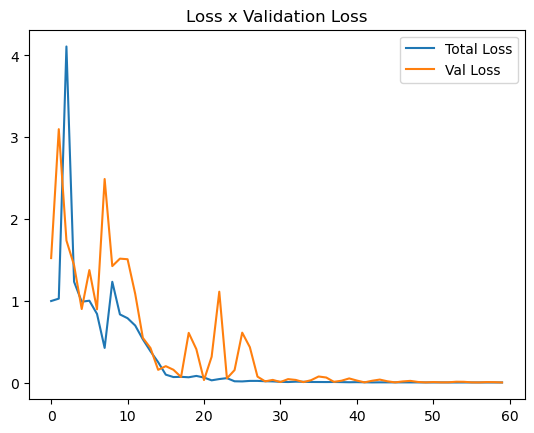

In [822]:
with torch.no_grad():

    plt.plot(total_loss, label = 'Total Loss')
    plt.plot(total_val_loss, label = 'Val Loss')
    plt.title('Loss x Validation Loss')
    plt.legend()

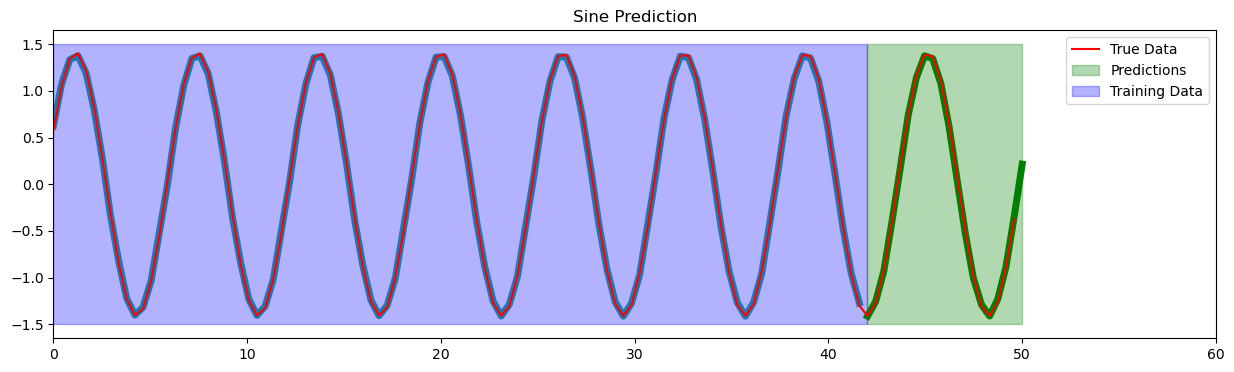

In [826]:
with torch.no_grad():

    RNNmodel.eval()

    yhat = RNNmodel(data_train, period = 20)
    
    fig, ax = plt.subplots(1,1, figsize=(15,4))
    # ax[0].plot(yhat[0])
    # ax[1].plot(data[0])
    ax.plot(x[:100],yhat[0][:100], linewidth = 5)
    ax.plot(x[100:],yhat[0][100:], linewidth = 5, color = 'green')
    ax.plot(x[:-1], data[0][1:], label = 'True Data', alpha= 1, color = 'red')
    # ax.vlines(100, -1.5,1.5, color = 'red')
    # ax[2].vlines(900, -1,1.2, color = 'red')
    plt.fill_betweenx(y = torch.arange(-1.5,2), x1 = 42, x2 = 50, color='green', alpha = 0.3, label= 'Predictions')
    plt.fill_betweenx(y = torch.arange(-1.5,2), x1 = 0, x2 = 42, color='blue', alpha = 0.3, label = 'Training Data')
    plt.xlim(0,60)
    plt.title('Sine Prediction')
    plt.legend()

In [591]:
total_val_loss[-1]  #Total val loss

tensor(0.0029)

We can see that the model was able to fit the sine and predict its future values. We also had a validation loss of 0.0029.

Now let's load our stock market data:

In [910]:
data = torch.tensor(load_data_norm()['y'], dtype=torch.float32).view(1,-1)

test = data[:,975:]
data_train = data[:,:975]


train_data = data_train[:,:-1]  #train data
train_target = data_train[:,1:]  #1 step ahead to predict target

test_data = test[:,:-1]    #test data
test_target = test[:,1:]


In [828]:
RNNmodel = RNN(hidden_dim=51)    #Load Model

In [839]:
loss_function = nn.MSELoss() #MSE loss

optimizer = optim.Adam(RNNmodel.parameters(), lr = 0.01, weight_decay=0,)  #Adam optim with weight decay to decrease overfitting.

In [840]:
def train(model):                #Train loop

    n_steps = 10

    period = 80                   

    total_loss = []
    total_val_loss = []

    for i in range(n_steps):

        RNNmodel.train()

        out = RNNmodel(train_data)

        loss = loss_function(out,train_target)

        total_loss.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f'loss = {loss}')
        
        with torch.no_grad():

            RNNmodel.eval()

            pred = RNNmodel(train_data, period)

            val_loss = loss_function(pred[:,-20:-1], data[:,pred.size(1) - pred[:,-20:-1].size(1):pred.size(1)]) #we compute the loss on 19 points 
                                                                                                                 #that were not used during training
            total_val_loss.append(val_loss)

            print(f'val loss = {val_loss}')

        # scheduler.step(val_loss)
    
    return total_loss, total_val_loss

In [841]:
total_loss, total_val_loss = train(RNNmodel)

loss = 0.013924899511039257
val loss = 0.05025434121489525
loss = 0.11607425659894943
val loss = 0.006866747513413429
loss = 0.019859986379742622
val loss = 0.0798630341887474
loss = 0.04399217665195465
val loss = 0.12851649522781372
loss = 0.07340843975543976
val loss = 0.09429875016212463
loss = 0.046197764575481415
val loss = 0.04013599082827568
loss = 0.017652910202741623
val loss = 0.010269170626997948
loss = 0.018794458359479904
val loss = 0.00601897994056344
loss = 0.034097280353307724
val loss = 0.0062633417546749115
loss = 0.039866894483566284
val loss = 0.007036732975393534


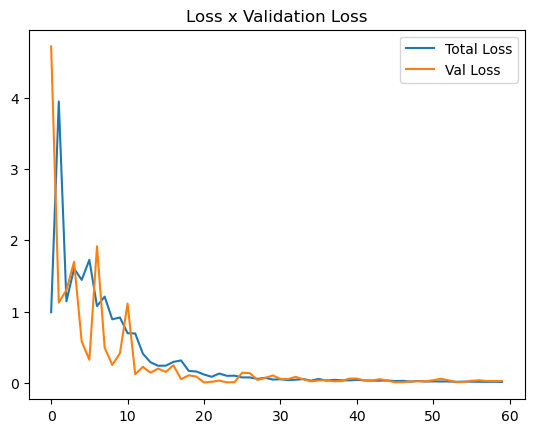

In [832]:
with torch.no_grad():

    plt.plot(total_loss, label = 'Total Loss')
    plt.plot(total_val_loss, label = 'Val Loss')
    plt.title('Loss x Validation Loss')
    plt.legend()

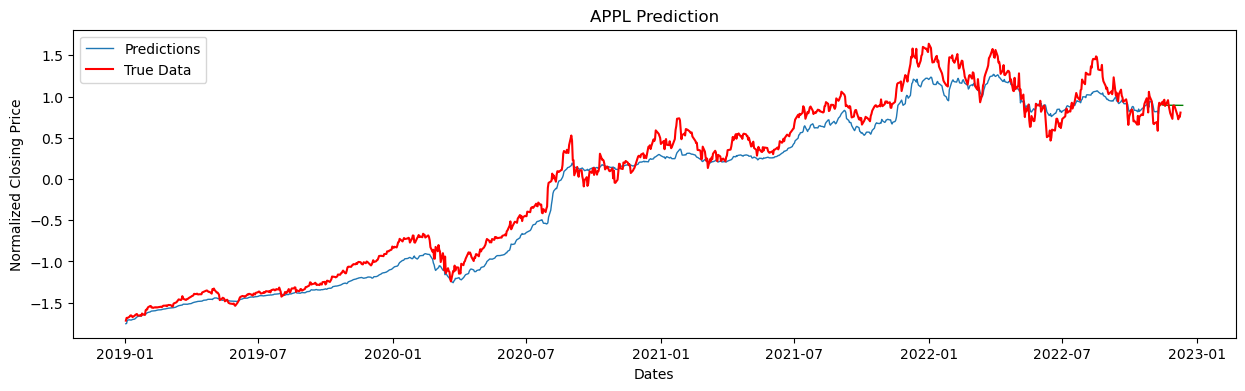

In [912]:
with torch.no_grad():

    RNNmodel.eval()

    yhat = RNNmodel(data_train, period = 20)
    x = load_data_norm().ds.array
    
    fig, ax = plt.subplots(1,1, figsize=(15,4))
    # ax[0].plot(yhat[0])
    # ax[1].plot(data[0])
    ax.plot(x[:975],yhat[0][:975], linewidth = 1, label = 'Predictions')
    ax.plot(x[975:],yhat[0][975:], linewidth = 1, color = 'green')
    ax.plot(x[:-1], data[0][1:], label = 'True Data', alpha= 1, color = 'red')
    # ax.vlines(x[975], -1.5,1.5, color = 'red')
    # ax.vlines(x[-1], -1,1.5, color = 'red')
    # plt.fill_betweenx(y = torch.arange(-1.5,2), x1 = 42, x2 = 50, color='green', alpha = 0.3, label= 'Predictions')
    # plt.fill_betweenx(y = torch.arange(-1.5,2), x1 = 0, x2 = 42, color='blue', alpha = 0.3, label = 'Training Data')
    # plt.xlim(0,60)
    plt.title('APPL Prediction')
    plt.xlabel('Dates')
    plt.ylabel('Normalized Closing Price')
    plt.legend()

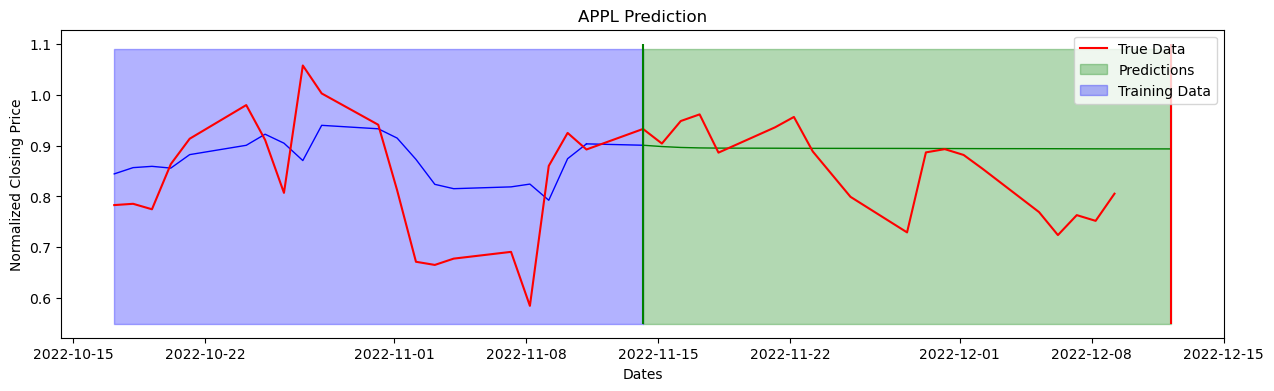

In [884]:
with torch.no_grad():

    RNNmodel.eval()

    yhat = RNNmodel(data_train, period = 20)
    x = load_data_norm().ds.array
    
    fig, ax = plt.subplots(1,1, figsize=(15,4))

    ax.plot(x[955:975],yhat[0][955:975], linewidth = 1, color = 'blue')
    ax.plot(x[974:976],yhat[0][974:976], linewidth = 1, color = 'blue')
    ax.plot(x[975:],yhat[0][975:], linewidth = 1, color = 'green')
    ax.plot(x[955:-1], data[0][956:], label = 'True Data', alpha= 1, color = 'red')
    ax.vlines(x[975], 0.55,1.1, color = 'green')
    ax.vlines(x[-1], 0.55,1.1, color = 'red')
    plt.fill_betweenx(y = torch.arange(0.55,1.1,0.01), x1 = x[975], x2 = x[-1], color='green', alpha = 0.3, label= 'Predictions')
    plt.fill_betweenx(y = torch.arange(0.55,1.1,0.01), x1 = x[955], x2 = x[975], color='blue', alpha = 0.3, label = 'Training Data')
    plt.title('APPL Prediction')
    plt.xlabel('Dates')
    plt.ylabel('Normalized Closing Price')
    plt.legend()

With only 80 steps of training we see that we can obtain a validation loss of 0.007036732975393534. We can also see that the model is starting to fit really well on the training data, in fact, it's very easy to overfit a LSTM on the training data, and with some more training steps this would happen. For the predictions, we see that with only hidden_dim = 51 the model is not able to fit the behavior of the data, but it makes some kind of linear regression.

A fine tuning of the LSTM would improve this result. We could add more hidden dimension and layers, and we could also play around with the learning rate and the weight decay to prevent over fitting and have better predictions. (check my project Weight Statistics on my GitHub)

The validation loss for the Prophet model was 0.033071435589437634, which is almost 5x bigger than the one for our toy LSTM. As we said before, this can be explained because the Prophet makes too many assumptions, and on the other side it looks like our simple LSTM is only showing the current trend.

As a final remark I would like to mention that the Prophet model is a very powerful and quick method, but it lacks complexity to predict a thing like the stock market, the good part of it is that it gives us the trends and the confidence gap.